In [21]:
from darknet import Darknet
import cv2
import matplotlib.pyplot as plt
from utils import *
import imutils
from imutils import perspective
from imutils import contours
import numpy as np
from scipy.spatial import distance as dist
from collections import defaultdict

In [22]:
cfg_file = './yolov3.cfg'

weight_file = './yolov3.weights'

namesfile = './coco.names'


m = Darknet(cfg_file)


m.load_weights(weight_file)


class_names = load_class_names(namesfile)

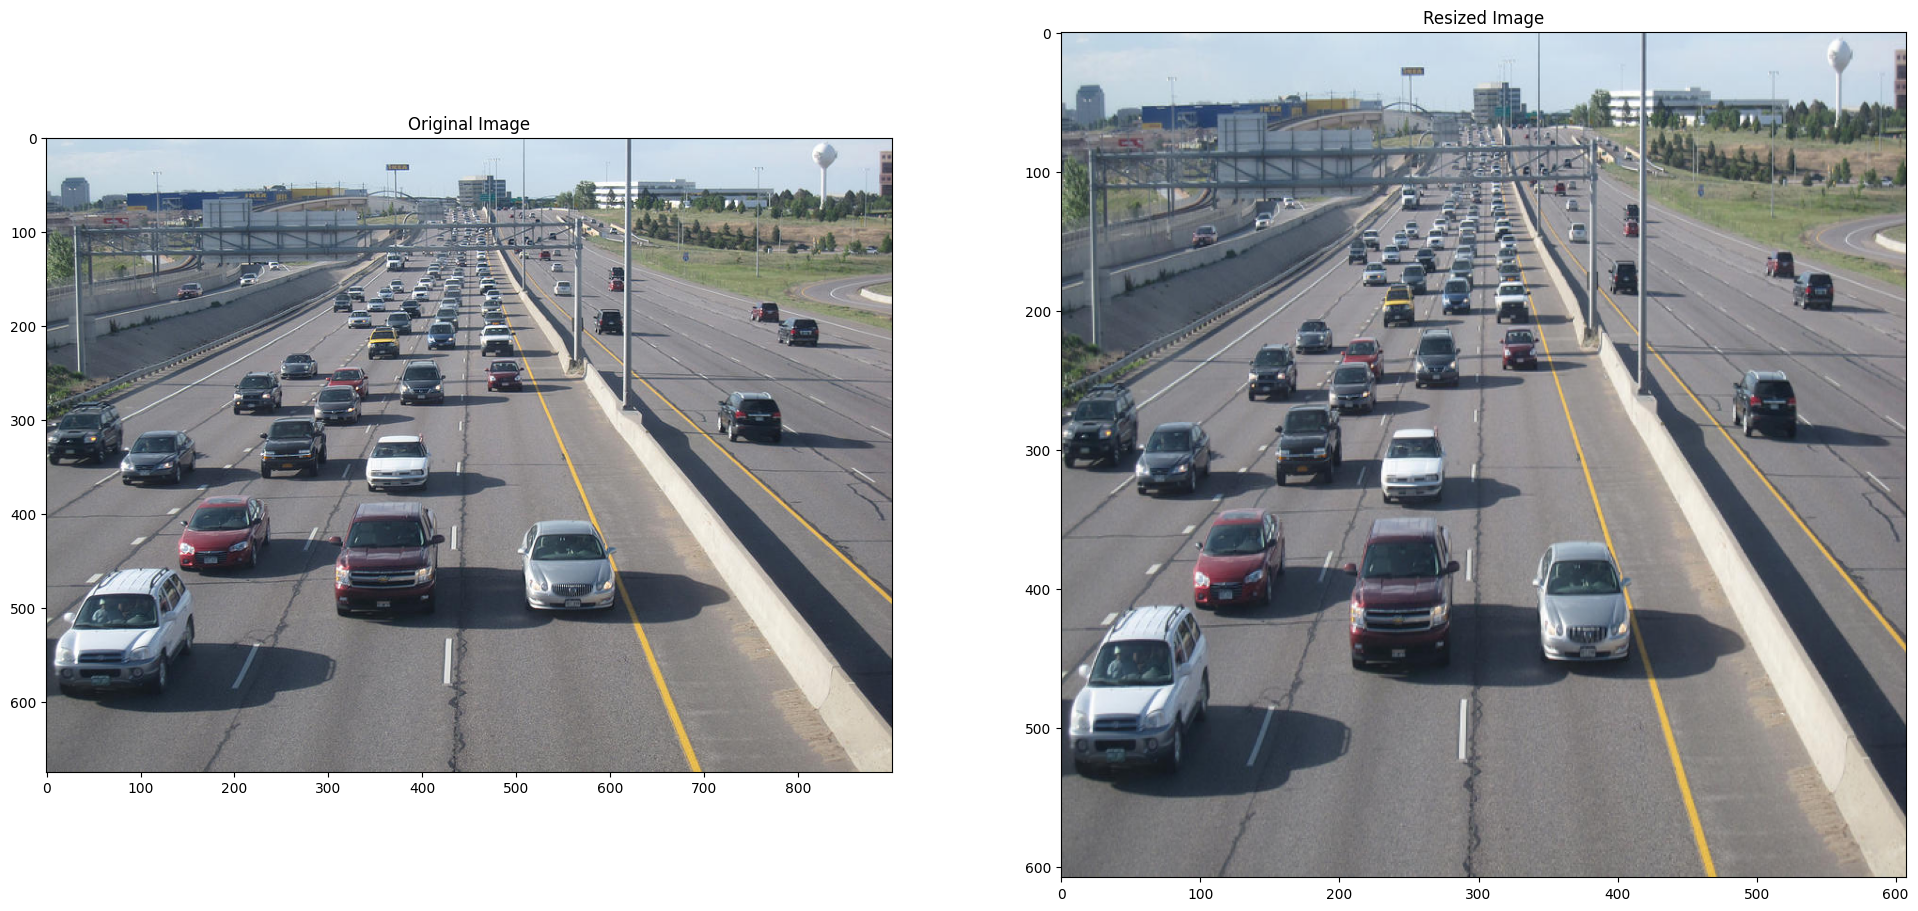

In [23]:

plt.rcParams['figure.figsize'] = [24.0, 14.0]
IMAGE = './input_images/low-traffic-in-denver-tammy-sutherland.jpg'

img = cv2.imread(IMAGE)


original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


resized_image = cv2.resize(original_image, (m.width, m.height))


plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()



It took 3.093 seconds to detect the objects in the image.

Number of Objects Detected: 38 

Objects Found and Confidence Level:

1. car: 0.999974
2. car: 0.999994
3. car: 0.999439
4. car: 0.999986
5. car: 0.999306
6. car: 0.693243
7. car: 0.994822
8. car: 0.999993
9. car: 0.995676
10. car: 0.981458
11. car: 0.999915
13. car: 0.823992
14. car: 0.995574
15. car: 0.995045
16. car: 0.999808
17. car: 0.999636
18. car: 0.999739
19. car: 0.999899
20. car: 0.999818
21. car: 0.999989
22. car: 0.998491
23. car: 0.999983
24. car: 0.998475
25. car: 0.999458
26. car: 0.999987
27. car: 0.999966
28. car: 0.999987
29. car: 0.999996
30. car: 0.999996
31. car: 0.999910
32. car: 0.999982
34. car: 0.999996
35. car: 0.951519
36. car: 0.999993
37. car: 0.991776
38. car: 0.999874


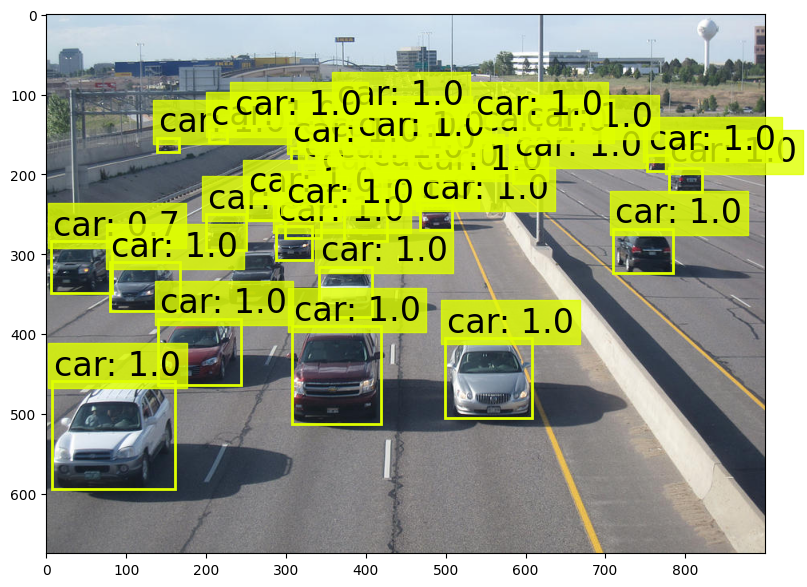

In [24]:

plt.rcParams['figure.figsize'] = [15.0, 7.0]


img = cv2.imread(IMAGE)


original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


resized_image = cv2.resize(original_image, (m.width, m.height))

iou_thresh = 0.4

nms_thresh = 0.6

boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)


print_objects(boxes, class_names)


plot_boxes(original_image, boxes, class_names, plot_labels = True)

In [16]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [25]:
image = cv2.imread(IMAGE)
box_measures = defaultdict(dict)
width = img.shape[1]
height = img.shape[0]
colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),(255, 0, 255))
for i, box in enumerate(boxes):    
    x1 = int(np.around((box[0] - box[2]/2.0) * width))
    y1 = int(np.around((box[1] - box[3]/2.0) * height))
    x2 = int(np.around((box[0] + box[2]/2.0) * width))
    y2 = int(np.around((box[1] + box[3]/2.0) * height))

    if x2-x1 > 50:
        box_measures["box"+str(i)] = {"top_left": (x1, y1), "top_right": (x2, y1),"bottom_right": (x2, y2),
                                  "bottom_left": (x1, y2), "center": (int((x1+x2)/2),int((y1+y2)/2))}

In [26]:
center = []
count = 0
box_array = np.zeros((4,2),dtype=int)
for key,v in box_measures.items():
    for i, (k,v) in enumerate(box_measures[key].items()):
        if i ==4:
            center.append((np.average(box_array[:, 0]), np.average(box_array[:, 1])))
            break
        box_array[i,count], box_array[i, count+1] = v[0],v[1]       

In [27]:
colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),(255, 0, 255))
box0_array = np.zeros((4,2),dtype=int)
count = 0
refObj = None
for key,v in box_measures.items():
    for i, (k,v) in enumerate(box_measures[key].items()):
        if i ==4:
            break
        box0_array[i,count], box0_array[i, count+1] = v[0],v[1]
        
    cX = np.average(box0_array[:, 0])
    cY = np.average(box0_array[:, 1])
    if refObj is None:
        
        (tl, tr, br, bl) = box0_array
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
        
        
        D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
        refObj = (box0_array, (cX, cY), D / 0.70)
        continue
    
    orig = image.copy()
    
    
    
    refCoords = np.vstack([refObj[0], refObj[1]])
    objCoords = np.vstack([box0_array, (cX, cY)])
    cv2.rectangle(orig, (refObj[0][0][0], refObj[0][0][1]),
                  (refObj[0][2][0], refObj[0][2][1]), (0, 255, 0), 2)    
    cv2.circle(orig, (int(refObj[1][0]), int(refObj[1][1])), 5, colors[0], -1)
    cv2.circle(orig, (int(cX), int(cY)), 5, colors[0], -1)
    cv2.line(orig, (int(refObj[1][0]), int(refObj[1][1])), (int(cX), int(cY)), colors[0], 2)

    
    D = dist.euclidean((refObj[1][0], refObj[1][1]), (cX, cY)) / refObj[2]
    (mX, mY) = midpoint((refObj[1][0], refObj[1][1]), (cX, cY))
    
    if D > 0.8: 
        cv2.putText(orig, "{:.1f}m".format(D), (int(mX), int(mY - 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, colors[1], 2)
        
        cv2.putText(orig, "No risk", (int(mX), int(mY + 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, colors[1], 2)
    else:
        cv2.putText(orig, "{:.1f}m".format(D), (int(mX), int(mY - 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, colors[0], 2)
        
        cv2.putText(orig, "Accident Risk", (int(mX), int(mY + 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, colors[0], 2)
        
    
    cv2.rectangle(orig, box_measures[key]["top_left"], box_measures[key]["bottom_right"],(255,0,0), 2)
    cv2.imshow("Image", orig)
    cv2.imwrite("./finalimg/image_"+key+".png", orig)
    cv2.waitKey(0)

In [38]:
import glob
import re
 
img_array = []
each_image_duration = 30
filenames = [ filename for filename in glob.glob("./finalimg/*.png")]
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))

for filename in filenames:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('acc_pred.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    for _ in range(each_image_duration):
        out.write(img_array[i])
out.release()

In [28]:
cv2.destroyAllWindows()